In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.17.1
1.26.4


In [2]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input

### 2) ResNet-34, ResNet-50 Complete Model
---

> ResNet 모델 구현 시 Sequential API나 Subclass API를 사용한다면, 그 과정에서 모델 단위로 기존의 코드를 재활용했을 때 model.summary() 호출 시 서브모델 내부의 레이어 구성이 생략되고 서브모델 단위로만 출력될 우려가 있습니다. 모델 구성만을 위해서는 그런 방법도 무방하지만, 가급적 이번 실습에서는 VGG 실습 예시에서처럼 Functional API 를 구성하는 방식을 사용할 것을 권합니다.

ResNet-34  

VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러 가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

다음의 코드를 실행하면,

```python
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()
```

In [3]:
def basic_block(x, filters, stride=1):
    """ResNet-34에서 사용되는 기본 basic_block

    인자:
        x: 입력 텐서
        filters: 합성곱 층에서 사용할 필터 수
        stride: 첫 번째 합성곱 층에서 사용할 스트라이드 값

    반환:
        기본 블록의 출력 텐서
    """
    shortcut = x  # 잔차 연결을 위해 입력 저장

    # 첫 번째 합성곱 블록
    x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)  # 3x3 합성곱
    x = layers.BatchNormalization()(x)  # 배치 정규화 적용
    x = layers.ReLU()(x)  # ReLU 활성화 함수 적용

    # 두 번째 합성곱 블록 (스트라이드 없음)
    x = layers.Conv2D(filters, 3, padding='same')(x)  # 3x3 합성곱
    x = layers.BatchNormalization()(x)

    # 스킵 연결에서 차원이 맞지 않는 경우 처리
    if stride != 1 or shortcut.shape[-1] != filters:
        # 1x1 합성곱으로 차원 맞추기 (공간 차원과 채널 수)
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # 스킵 연결 추가 및 ReLU 적용
    x = layers.Add()([shortcut, x])  # 잔차 연결
    x = layers.ReLU()(x)  # 최종 활성화

    return x

### 참고 : 입력 텐서(shortcut)와 출력 텐서(x)의 차원이 일치하는지 확인
1. 공간 차원(spatial dimensions):
    - stride != 1일 경우, 블록 내부에서 다운샘플링이 발생했음을 의미
    - 다운샘플링 시, 입력 텐서의 공간 크기와 출력 텐서의 크기가 다르기 때문에, 스킵 연결에 맞추기 위해 입력 텐서의 크기를 조정

2. 채널 수(channel dimensions):
    - shortcut.shape[-1] != filters * 4: ResNet의 Bottleneck 구조에서는 출력 텐서의 채널 수가 기본 필터 수(filters)의 4배(예. 256 과 64)
    - 입력 텐서(shortcut)의 채널 수가 출력 텐서와 다르면, 스킵 연결에 맞추기 위해 채널 수를 조정

In [4]:
def bottleneck_block(x, filters, stride=1):
    """ResNet-50 이상의 더 깊은 버전에서 사용되는 bottleneck_block

    인자:
        x: 입력 텐서
        filters: 주요 합성곱 층의 필터 수
        stride: 주요 합성곱 층의 스트라이드 값

    반환:
        병목 블록의 출력 텐서
    """
    shortcut = x  # 잔차 연결을 위해 입력 저장

    # 첫 번째 1x1 합성곱 - 차원 감소
    x = layers.Conv2D(filters, 1, strides=1)(x)  # 채널 수 감소
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 3x3 합성곱 - 주요 공간 연산
    x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 마지막 1x1 합성곱 - 차원 복원 및 확장
    x = layers.Conv2D(filters * 4, 1)(x)  # 채널 수 증가 (4배)
    x = layers.BatchNormalization()(x)

    # 스킵 연결에서 차원이 맞지 않는 경우 처리
    if stride != 1 or shortcut.shape[-1] != filters * 4:
        shortcut = layers.Conv2D(filters * 4, 1, strides=stride)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # 스킵 연결 추가 및 ReLU 적용
    x = layers.Add()([shortcut, x])  # 잔차 연결
    x = layers.ReLU()(x)  # 최종 활성화

    return x

In [5]:
def build_resnet(input_shape=(32, 32, 3), is_50=False):
    """설정에 따라 ResNet 모델(34 또는 50)을 구축

    인자:
        input_shape: 입력 이미지의 형태 (높이, 너비, 채널)
        is_50: ResNet-50(True) 또는 ResNet-34(False) 선택을 위한 불리언 값

    반환:
        컴파일된 ResNet 모델
    """
    # 입력 층 생성
    inputs = Input(shape=input_shape)

    # 초기 합성곱 블록
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)  # 초기 7x7 합성곱
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)  # 3x3 최대 풀링

    # 모델 버전에 따른 블록 유형과 설정 선택
    if is_50:
        # ResNet-50 설정
        block_fn = bottleneck_block  # 병목 블록 사용
        filters = [64, 128, 256, 512]  # 각 단계별 기본 필터 수
        blocks = [3, 4, 6, 3]  # 각 단계별 블록 수
    else:
        # ResNet-34 설정
        block_fn = basic_block  # 기본 블록 사용
        filters = [64, 128, 256, 512]  # 각 단계별 기본 필터 수
        blocks = [3, 4, 6, 3]  # 각 단계별 블록 수

    # 단계별 생성
    for stage, (filter_size, block_count) in enumerate(zip(filters, blocks)):
        for block_idx in range(block_count):
            # 각 단계의 첫 번째 블록(첫 단계 제외)에서 스트라이드 2 사용
            stride = 2 if block_idx == 0 and stage > 0 else 1
            x = block_fn(x, filter_size, stride=stride)

    # 최종 층
    x = layers.GlobalAveragePooling2D()(x)  # 전역 평균 풀링
    x = layers.Dense(10, activation='softmax')(x)  # 분류 층

    # 모델 생성 및 반환
    return Model(inputs, x)

In [6]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 64)     │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 16, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 16, 16, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 8, 8, 64)       │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 64)       │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 8, 8, 64)       │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 8, 8, 64)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 8, 8, 64)       │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 8, 8, 64)       │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 8, 8, 64)       │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 8, 8, 64)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 8, 8, 64)       │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 8, 8, 64)       │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 8, 8, 64)       │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 64)       │         36,928 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 21,315,338 (81.31 MB)

 Trainable params: 21,298,314 (81.25 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [7]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 16, 16, 64)     │          9,472 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 16, 16, 64)     │            256 │ conv2d_36[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_33 (ReLU)           │ (None, 16, 16, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 64)       │              0 │ re_lu_33[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 8, 8, 64)       │          4,160 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 8, 8, 64)       │            256 │ conv2d_37[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_34 (ReLU)           │ (None, 8, 8, 64)       │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 8, 8, 64)       │         36,928 │ re_lu_34[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 8, 8, 64)       │            256 │ conv2d_38[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_35 (ReLU)           │ (None, 8, 8, 64)       │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 8, 8, 256)      │         16,640 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 8, 8, 256)      │         16,640 │ re_lu_35[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_40    │ (None, 8, 8, 256)      │          1,024 │ conv2d_40[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 8, 8, 256)      │          1,024 │ conv2d_39[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)              │ (None, 8, 8, 256)      │              0 │ batch_normalization_4… │
│                      

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

### 3) 일반 네트워크(plain network) 만들기
---
블록 코드 수정하기  

우리는 앞에서 ResNet 모델을 구현했습니다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 주세요!

전체 함수 코드 수정하기  

이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()를 만들어 보세요. 이때 입력 이미지의 크기는 (224, 224, 3)으로 해주세요.

In [8]:
def basic_block(x, filters, stride=1, use_skip=True):
    """기본 블록 - ResNet-34와 PlainNet-34에서 사용

    인자:
        x: 입력 텐서
        filters: 합성곱 층의 필터 수
        stride: 첫 번째 합성곱 층의 스트라이드 값
        use_skip: skip connection 사용 여부 (ResNet vs PlainNet)

    반환:
        블록의 출력 텐서
    """
    shortcut = x  # skip connection을 위해 입력 저장

    # 첫 번째 합성곱 블록
    x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 두 번째 합성곱 블록
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    if use_skip:  # ResNet의 경우에만 skip connection 적용
        if stride != 1 or shortcut.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        x = layers.Add()([shortcut, x])

    x = layers.ReLU()(x)
    return x


In [9]:
def bottleneck_block(x, filters, stride=1, use_skip=True):
    """병목 블록 - ResNet-50과 PlainNet-50에서 사용

    인자:
        x: 입력 텐서
        filters: 주 합성곱 층의 필터 수
        stride: 주 합성곱 층의 스트라이드 값
        use_skip: skip connection 사용 여부 (ResNet vs PlainNet)

    반환:
        블록의 출력 텐서
    """
    shortcut = x  # skip connection을 위해 입력 저장

    # 첫 번째 1x1 합성곱 (차원 감소)
    x = layers.Conv2D(filters, 1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 3x3 합성곱
    x = layers.Conv2D(filters, 3, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 마지막 1x1 합성곱 (차원 확장)
    x = layers.Conv2D(filters * 4, 1)(x)
    x = layers.BatchNormalization()(x)

    if use_skip:  # ResNet의 경우에만 skip connection 적용
        if stride != 1 or shortcut.shape[-1] != filters * 4:
            shortcut = layers.Conv2D(filters * 4, 1, strides=stride)(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)
        x = layers.Add()([shortcut, x])

    x = layers.ReLU()(x)
    return x

In [10]:
def build_network(is_50=False, use_skip=True):
    """ResNet 또는 PlainNet 모델 생성

    인자:
        is_50: 50층 모델(True) 또는 34층 모델(False) 선택
        use_skip: ResNet(True) 또는 PlainNet(False) 선택

    반환:
        구축된 모델
    """
    inputs = Input(shape=(224, 224, 3))
    # 초기 합성곱 블록
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # 모델 구성 설정
    if is_50:
        block_fn = bottleneck_block
        filters = [64, 128, 256, 512]
        blocks = [3, 4, 6, 3]
    else:
        block_fn = basic_block
        filters = [64, 128, 256, 512]
        blocks = [3, 4, 6, 3]

    # 스테이지별 블록 생성
    for stage, (filter_size, block_count) in enumerate(zip(filters, blocks)):
        for block_idx in range(block_count):
            stride = 2 if block_idx == 0 and stage > 0 else 1
            x = block_fn(x, filter_size, stride=stride, use_skip=use_skip)

    # 최종 분류 층
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(10, activation='softmax')(x)

    return Model(inputs, x)

In [11]:
# 모델 생성 함수들
def build_resnet(is_50=False):
    """ResNet 모델 생성"""
    return build_network(is_50=is_50, use_skip=True)

In [12]:
def build_plainnet(is_50=False):
    """PlainNet 모델 생성"""
    return build_network(is_50=is_50, use_skip=False)

In [13]:
# 모델 생성
resnet_34 = build_resnet(is_50=False)
resnet_50 = build_resnet(is_50=True)
plainnet_34 = build_plainnet(is_50=False)
plainnet_50 = build_plainnet(is_50=True)

In [14]:
# 모델 구조 확인
resnet_34.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_89 (Conv2D)        │ (None, 112, 112, 64)   │          9,472 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_89    │ (None, 112, 112, 64)   │            256 │ conv2d_89[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_82 (ReLU)           │ (None, 112, 112, 64)   │              0 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 56, 56, 64)     │              0 │ re_lu_82[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_90 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_90    │ (None, 56, 56, 64)     │            256 │ conv2d_90[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_83 (ReLU)           │ (None, 56, 56, 64)     │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_91 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ re_lu_83[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_91    │ (None, 56, 56, 64)     │            256 │ conv2d_91[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_32 (Add)              │ (None, 56, 56, 64)     │              0 │ max_pooling2d_2[0][0], │
│                           │                        │                │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_84 (ReLU)           │ (None, 56, 56, 64)     │              0 │ add_32[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_92 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ re_lu_84[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_92    │ (None, 56, 56, 64)     │            256 │ conv2d_92[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_85 (ReLU)           │ (None, 56, 56, 64)     │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_93 (Conv2D)        │ (None, 56, 56, 64)     │         36,928 │ re_lu_85[0][0]         │
├──────────────────────

 Total params: 21,315,338 (81.31 MB)

 Trainable params: 21,298,314 (81.25 MB)

 Non-trainable params: 17,024 (66.50 KB)

In [15]:
# 모델 구조 확인
resnet_50.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_125 (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_125   │ (None, 112, 112, 64)   │            256 │ conv2d_125[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_115 (ReLU)          │ (None, 112, 112, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 56, 56, 64)     │              0 │ re_lu_115[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_126 (Conv2D)       │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_126   │ (None, 56, 56, 64)     │            256 │ conv2d_126[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_116 (ReLU)          │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_127 (Conv2D)       │ (None, 56, 56, 64)     │         36,928 │ re_lu_116[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_127   │ (None, 56, 56, 64)     │            256 │ conv2d_127[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_117 (ReLU)          │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_129 (Conv2D)       │ (None, 56, 56, 256)    │         16,640 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_128 (Conv2D)       │ (None, 56, 56, 256)    │         16,640 │ re_lu_117[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_129   │ (None, 56, 56, 256)    │          1,024 │ conv2d_129[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_128   │ (None, 56, 56, 256)    │          1,024 │ conv2d_128[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_48 (Add)              │ (None, 56, 56, 256)    │              0 │ batch_normalization_1… │
│                      

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [16]:
# 모델 구조 확인
plainnet_34.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_178 (Conv2D)                  │ (None, 112, 112, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_178              │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_164 (ReLU)                     │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_179 (Conv2D)                  │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_179              │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_165 (ReLU)                     │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_180 (Conv2D)                  │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_180              │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_166 (ReLU)                     │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_181 (Conv2D)                  │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_181              │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_167 (ReLU)                     │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_182 (Conv2D)                  │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_182              │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_168 (ReLU)                     │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_183 (Conv2D)                  │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_183              │ (None, 56, 56, 64)          │             2

 Total params: 21,138,826 (80.64 MB)

 Trainable params: 21,123,594 (80.58 MB)

 Non-trainable params: 15,232 (59.50 KB)

In [17]:
# 모델 구조 확인
plainnet_50.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_211 (Conv2D)                  │ (None, 112, 112, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_211              │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_197 (ReLU)                     │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_212 (Conv2D)                  │ (None, 56, 56, 64)          │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_212              │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_198 (ReLU)                     │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_213 (Conv2D)                  │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_213              │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_199 (ReLU)                     │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_214 (Conv2D)                  │ (None, 56, 56, 256)         │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_214              │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_200 (ReLU)                     │ (None, 56, 56, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_215 (Conv2D)                  │ (None, 56, 56, 64)          │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_215              │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_201 (ReLU)                     │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_216 (Conv2D)                  │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_216              │ (None, 56, 56, 64)          │             2

 Total params: 20,820,106 (79.42 MB)

 Trainable params: 20,774,666 (79.25 MB)

 Non-trainable params: 45,440 (177.50 KB)

### 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34
Ablation Study

이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터 수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해 주세요.

어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.

혹시 에러가 발생했나요? 그렇다면 다음의 링크를 읽어보세요

tensorflow_datasets.load('cats_vs_dogs') not working ! https://github.com/tensorflow/datasets/issues/3918

### cats_vs_dogs 다운로드(colab 에서는 다운에러 안남, 데이터셋 준비 과정에서 손상된 이미지가 제외)

In [18]:
# Load the Cats and Dogs dataset
(dataset_train, dataset_test), dataset_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

# Print dataset information
print("Dataset Info:")
print(dataset_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.Y2VPGN_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Dataset Info:
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir=PosixGPath('/tmp/tmpcv1y8iwmtfds'),
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-

In [19]:
# num_classes 설정
num_classes = dataset_info.features['label'].num_classes
print(num_classes)

2


In [20]:
# Define a function to preprocess the data
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize images to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Apply preprocessing and prepare batches
batch_size = 32

train_ds = (dataset_train
                 .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                 .shuffle(1000)
                 .batch(batch_size)
                 .prefetch(tf.data.AUTOTUNE))

validation_ds = (dataset_test
                .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(batch_size)
                .prefetch(tf.data.AUTOTUNE))


### 이미지 확인용 출력 함수

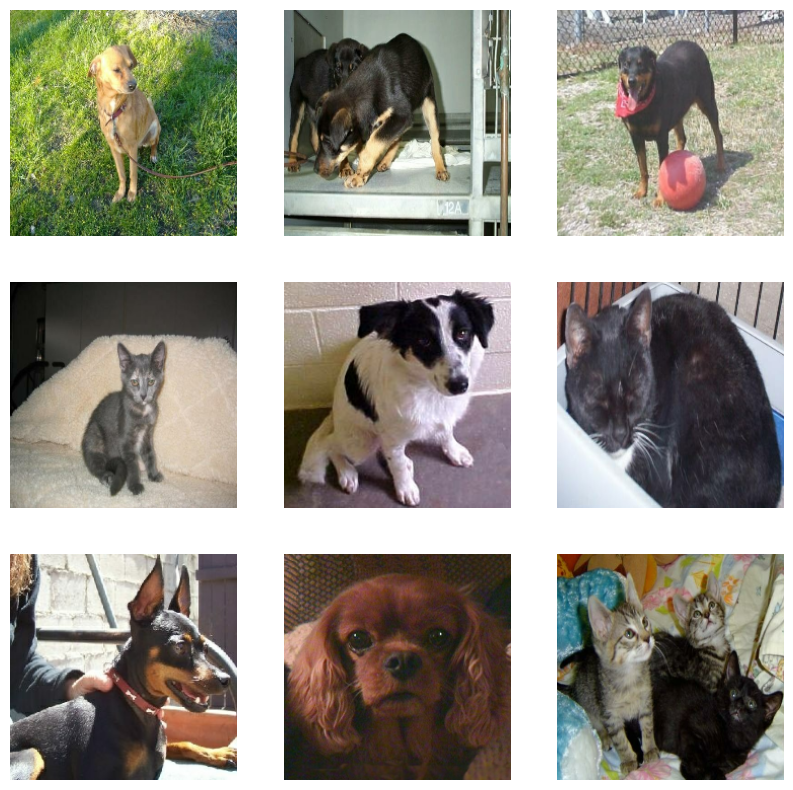

In [21]:
# Display 9 images from the dataset
def display_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i])
            plt.axis("off")
    plt.show()

# Display images from the training dataset
display_images(train_ds)


In [22]:
# Example of accessing a batch of data
for images, labels in train_ds.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch of labels shape: {labels.shape}")

Batch of images shape: (32, 224, 224, 3)
Batch of labels shape: (32,)


### 이진 분류 모델을 위해 출력층 수정 및 컴파일

In [23]:
def modify_and_compile_model(model, num_classes):
    model.layers.pop()  # 기존 출력층 제거
    outputs = tf.keras.layers.Dense(num_classes)(model.layers[-1].output)
    model = tf.keras.Model(inputs=model.input, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

In [37]:
# 기존 레이어를 제거하지 않고 좀 더 안전한 방법
def safety_modify_and_compile_model(model, num_classes):
    outputs = tf.keras.layers.Dense(num_classes)(model.layers[-2].output)
    model = tf.keras.Model(inputs=model.input, outputs=outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

In [24]:
# 모델들 수정 및 컴파일
resnet_34 = modify_and_compile_model(resnet_34, num_classes)
resnet_50 = modify_and_compile_model(resnet_50, num_classes)
plainnet_34 = modify_and_compile_model(plainnet_34, num_classes)
plainnet_50 = modify_and_compile_model(plainnet_50, num_classes)

### 모델 별 학습


In [25]:
EPOCH = 10

In [26]:
# 콜백 설정
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

In [27]:
print("\nResNet-34 학습 중...")
resnet34_history = resnet_34.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCH,
    verbose=1,
    # callbacks=callbacks
)


ResNet-34 학습 중...
Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 171s 231ms/step - accuracy: 0.5598 - loss: 0.6911 - val_accuracy: 0.5125 - val_loss: 0.7016
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 121s 207ms/step - accuracy: 0.5512 - loss: 0.6882 - val_accuracy: 0.4811 - val_loss: 0.7075
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 121s 206ms/step - accuracy: 0.5438 - loss: 0.6891 - val_accuracy: 0.5099 - val_loss: 0.6930
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 121s 207ms/step - accuracy: 0.5038 - loss: 0.6931 - val_accuracy: 0.5099 - val_loss: 0.6930
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 120s 206ms/step - accuracy: 0.5018 - loss: 0.6932 - val_accuracy: 0.5327 - val_loss: 0.6923
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 120s 206ms/step - accuracy: 0.5363 - loss: 0.6900 - val_accuracy: 0.4819 - val_loss: 0.6950
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 120s 205ms/step - accuracy: 0.5197 - loss: 0.6919 - val_accuracy: 0.5120 - val_loss: 0.6937
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 120s 206ms/step -

In [28]:
print("\nResNet-50 학습 중...")
resnet50_history = resnet_50.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCH,
    verbose=1,
    # callbacks=callbacks
)


ResNet-50 학습 중...
Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 300s 420ms/step - accuracy: 0.5123 - loss: 0.6947 - val_accuracy: 0.5129 - val_loss: 0.6947
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 213s 366ms/step - accuracy: 0.5354 - loss: 0.6896 - val_accuracy: 0.5209 - val_loss: 0.6945
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 212s 363ms/step - accuracy: 0.5111 - loss: 0.6925 - val_accuracy: 0.5099 - val_loss: 0.6930
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 212s 364ms/step - accuracy: 0.5237 - loss: 0.6904 - val_accuracy: 0.4929 - val_loss: 0.6933
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 212s 364ms/step - accuracy: 0.5100 - loss: 0.6930 - val_accuracy: 0.5267 - val_loss: 0.6918
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 212s 364ms/step - accuracy: 0.5101 - loss: 0.6928 - val_accuracy: 0.5099 - val_loss: 0.6930
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 212s 363ms/step - accuracy: 0.5038 - loss: 0.6931 - val_accuracy: 0.5099 - val_loss: 0.6930
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 213s 365ms/step -

In [29]:
print("\nPlainNet-34 학습 중...")
plainnet34_history = plainnet_34.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCH,
    verbose=1,
    # callbacks=callbacks
)


PlainNet-34 학습 중...
Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 159s 222ms/step - accuracy: 0.5098 - loss: 0.6935 - val_accuracy: 0.5105 - val_loss: 0.6930
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 115s 196ms/step - accuracy: 0.5082 - loss: 0.6927 - val_accuracy: 0.4832 - val_loss: 0.6997
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 114s 195ms/step - accuracy: 0.5368 - loss: 0.6883 - val_accuracy: 0.4968 - val_loss: 0.7090
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 113s 194ms/step - accuracy: 0.4999 - loss: 0.6938 - val_accuracy: 0.4948 - val_loss: 0.6933
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 114s 194ms/step - accuracy: 0.5046 - loss: 0.6930 - val_accuracy: 0.5520 - val_loss: 0.6882
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 114s 195ms/step - accuracy: 0.5240 - loss: 0.6925 - val_accuracy: 0.5135 - val_loss: 0.6930
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 114s 196ms/step - accuracy: 0.5079 - loss: 0.6931 - val_accuracy: 0.5099 - val_loss: 0.6930
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 114s 196ms/step

In [30]:
print("\nPlainNet-50 학습 중...")
plainnet50_history = plainnet_50.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCH,
    verbose=1,
    # callbacks=callbacks
)


PlainNet-50 학습 중...
Epoch 1/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 248s 349ms/step - accuracy: 0.5221 - loss: 0.6938 - val_accuracy: 0.5099 - val_loss: 0.6930
Epoch 2/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 180s 309ms/step - accuracy: 0.5272 - loss: 0.6908 - val_accuracy: 0.4716 - val_loss: 0.7038
Epoch 3/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 179s 307ms/step - accuracy: 0.5160 - loss: 0.6936 - val_accuracy: 0.4914 - val_loss: 0.6945
Epoch 4/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 179s 307ms/step - accuracy: 0.5164 - loss: 0.6927 - val_accuracy: 0.5529 - val_loss: 0.6877
Epoch 5/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 179s 306ms/step - accuracy: 0.5065 - loss: 0.6932 - val_accuracy: 0.5396 - val_loss: 0.6902
Epoch 6/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 179s 306ms/step - accuracy: 0.5221 - loss: 0.6897 - val_accuracy: 0.4899 - val_loss: 0.7206
Epoch 7/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 179s 307ms/step - accuracy: 0.5066 - loss: 0.6944 - val_accuracy: 0.5630 - val_loss: 0.6842
Epoch 8/10
582/582 ━━━━━━━━━━━━━━━━━━━━ 179s 306ms/step

In [46]:
def plot_metrics(history, model_name):
    """모델의 훈련 및 검증 손실과 정확도를 하나의 행에 그리기"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # 손실 그래프 (훈련 + 검증)
    axes[0].plot(history.history['loss'], label=f'{model_name} (Train)')
    axes[0].plot(history.history['val_loss'], label=f'{model_name} (Validation)')
    axes[0].set_title(f'{model_name} Loss (Train & Validation)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # 정확도 그래프 (훈련 + 검증)
    axes[1].plot(history.history['accuracy'], label=f'{model_name} (Train)')
    axes[1].plot(history.history['val_accuracy'], label=f'{model_name} (Validation)')
    axes[1].set_title(f'{model_name} Accuracy (Train & Validation)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


ResNet-34


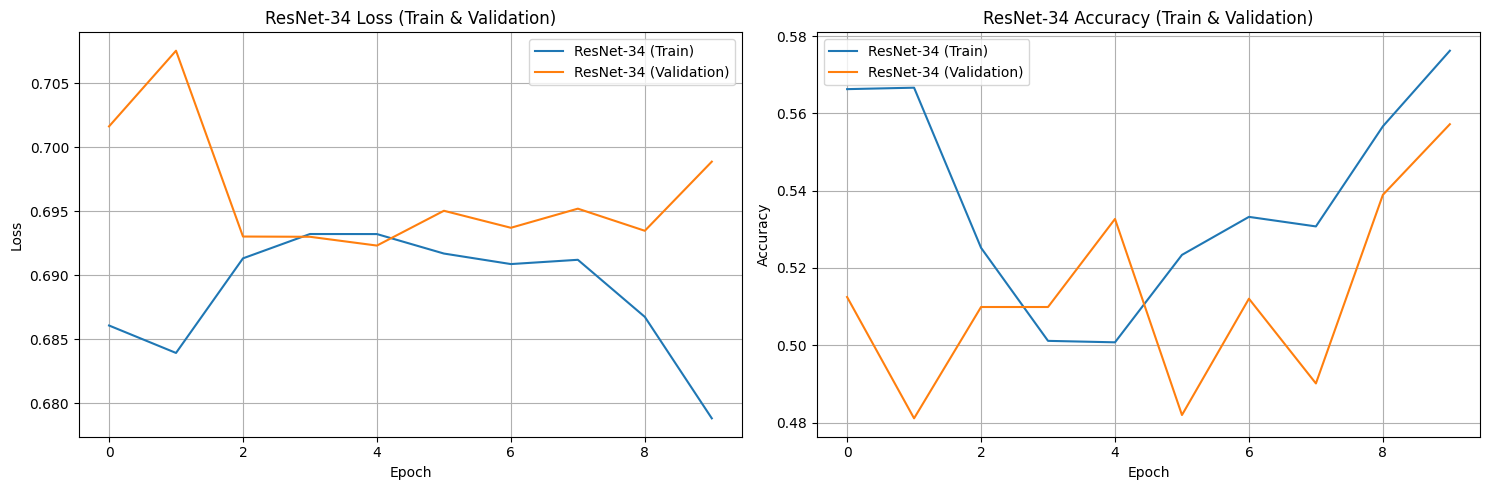

In [47]:
print("\nResNet-34")
plot_metrics(resnet34_history, 'ResNet-34')


ResNet-50


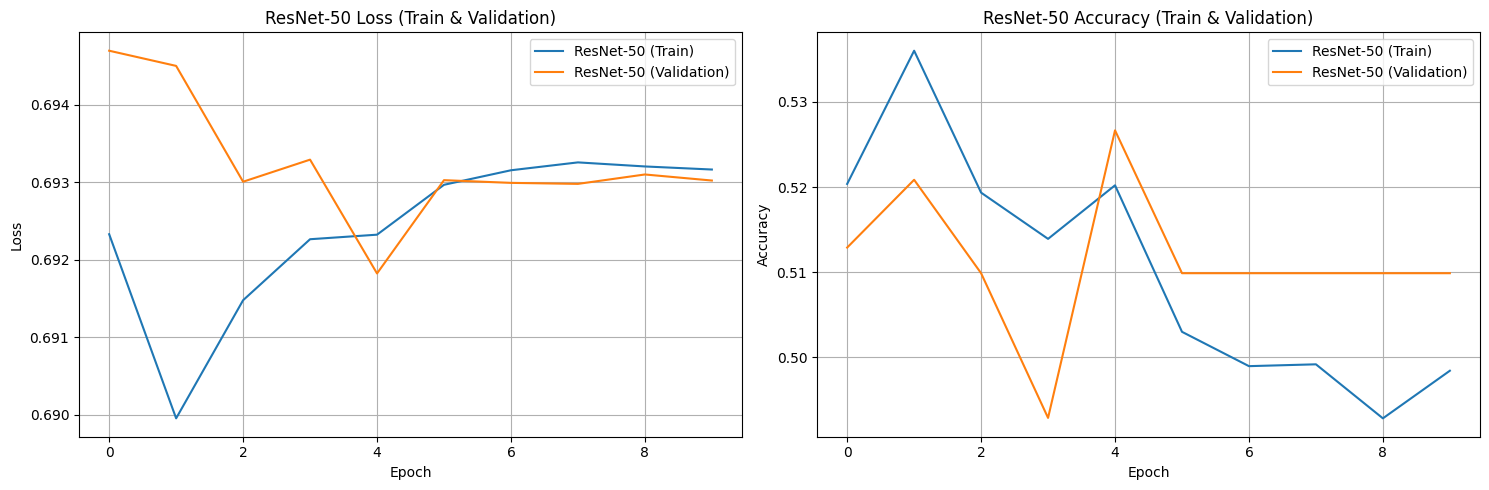

In [48]:
print("\nResNet-50")
plot_metrics(resnet50_history, 'ResNet-50')


PlainNet-34


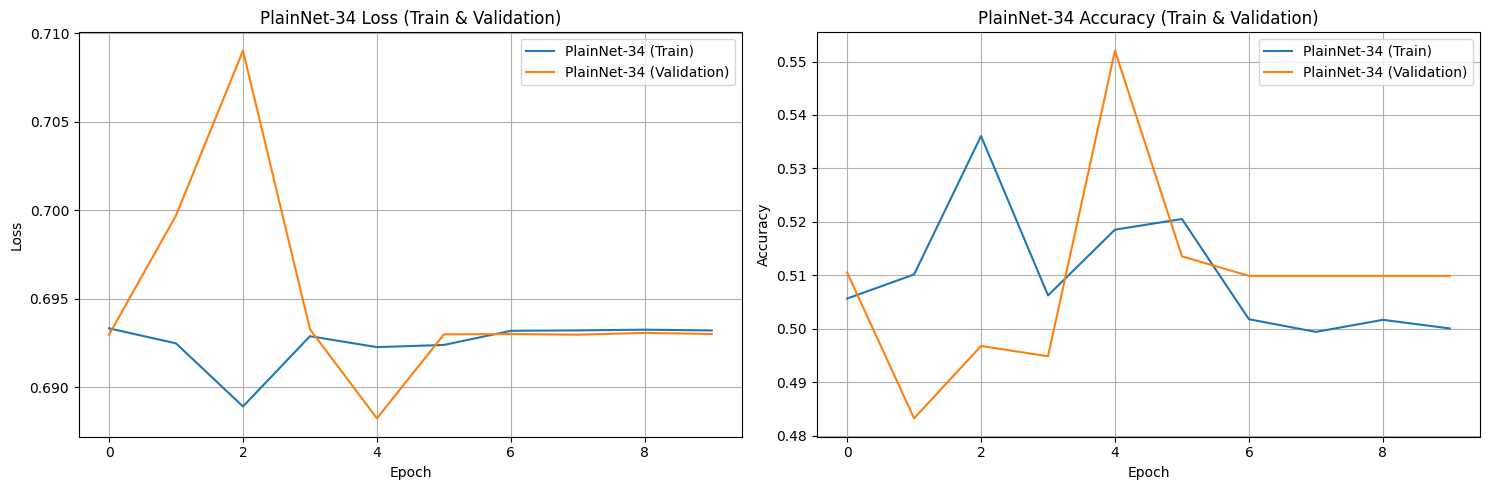

In [49]:
print("\nPlainNet-34")
plot_metrics(plainnet34_history, 'PlainNet-34')


PlainNet-50


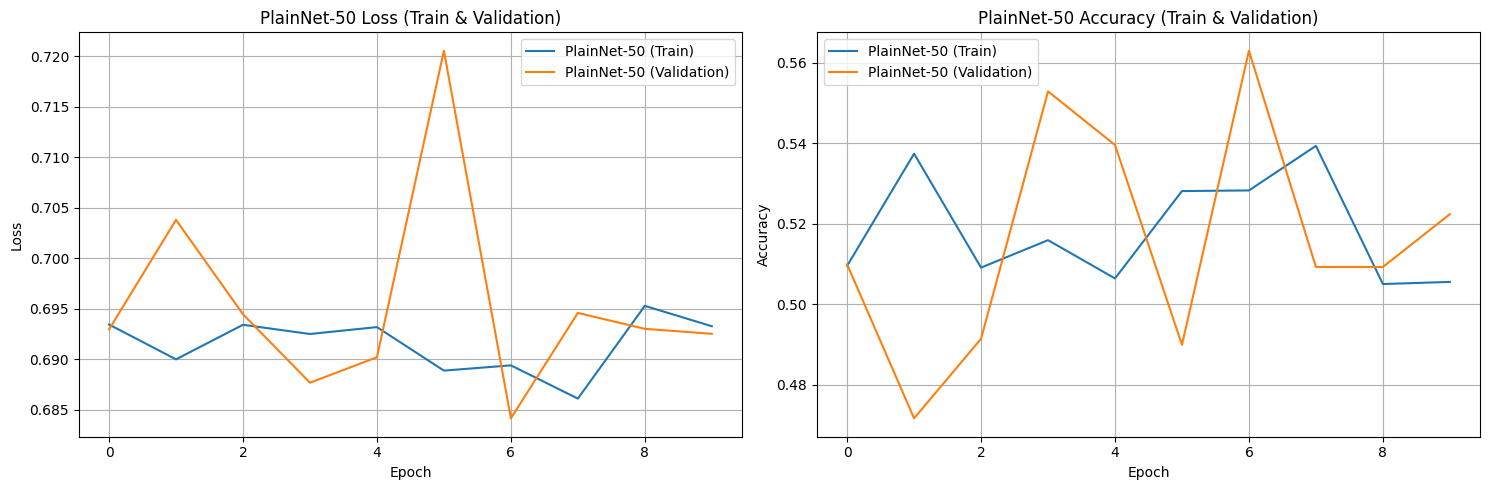

In [50]:
print("\nPlainNet-50")
plot_metrics(plainnet50_history, 'PlainNet-50')

### 시각화  

학습을 통해 만들어진 history를 matplotlib로 시각화하여 두 모델의 검증 정확도(validation accuracy)와 검증 손실(validation loss)이 어떻게 다른지 살펴봅시다.

In [31]:
def compare_models(history1, history2, model1_name, model2_name):
    """두 모델의 검증 손실과 정확도 비교"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 검증 손실 그래프
    ax1.plot(history1.history['val_loss'], label=model1_name)
    ax1.plot(history2.history['val_loss'], label=model2_name)
    ax1.set_title('Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # 검증 정확도 그래프
    ax2.plot(history1.history['val_accuracy'], label=model1_name)
    ax2.plot(history2.history['val_accuracy'], label=model2_name)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

### 결과 비교


ResNet-34 vs ResNet-50 비교


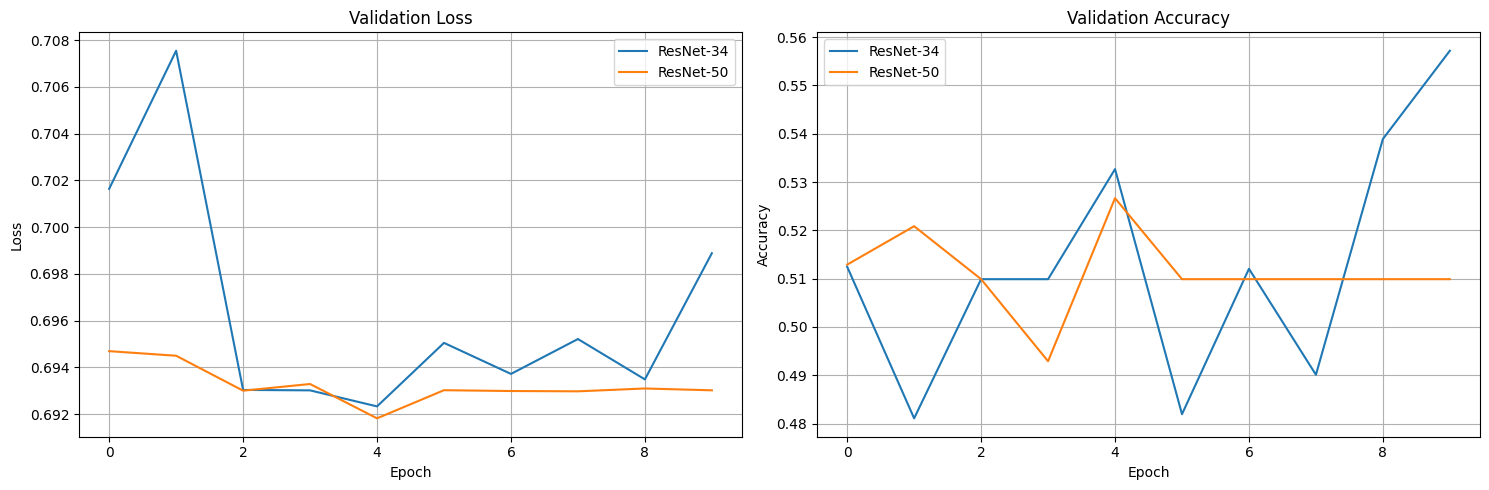

In [32]:
print("\nResNet-34 vs ResNet-50 비교")
compare_models(resnet34_history, resnet50_history, 'ResNet-34', 'ResNet-50')


ResNet-34 vs PlainNet-34 비교


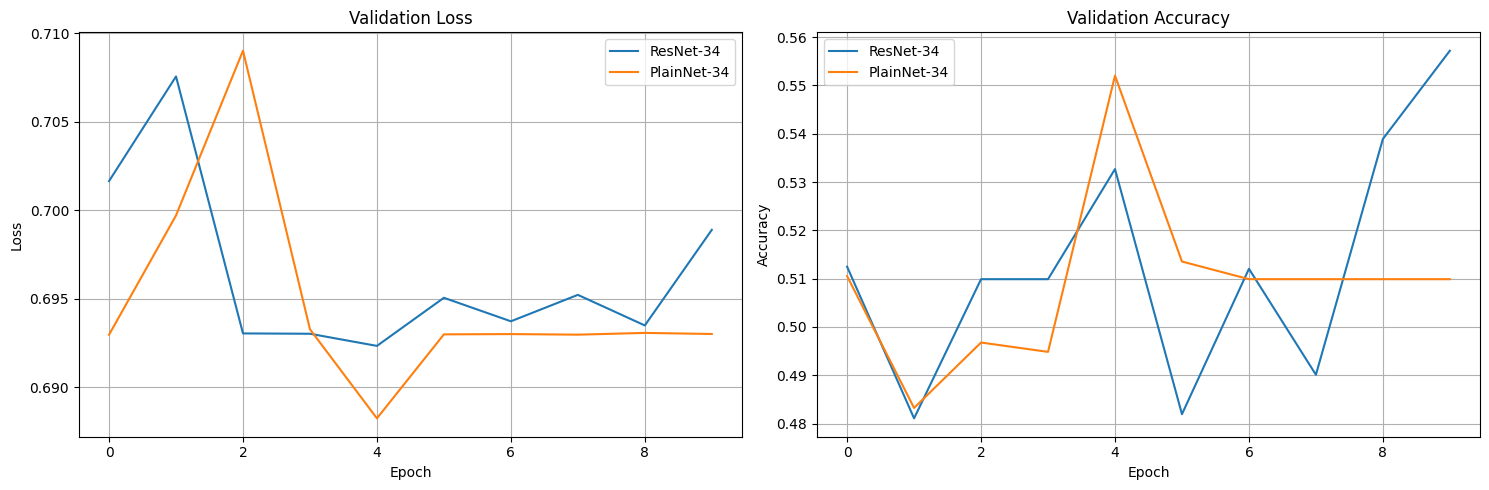

In [33]:
print("\nResNet-34 vs PlainNet-34 비교")
compare_models(resnet34_history, plainnet34_history, 'ResNet-34', 'PlainNet-34')


ResNet-50 vs PlainNet-50 비교


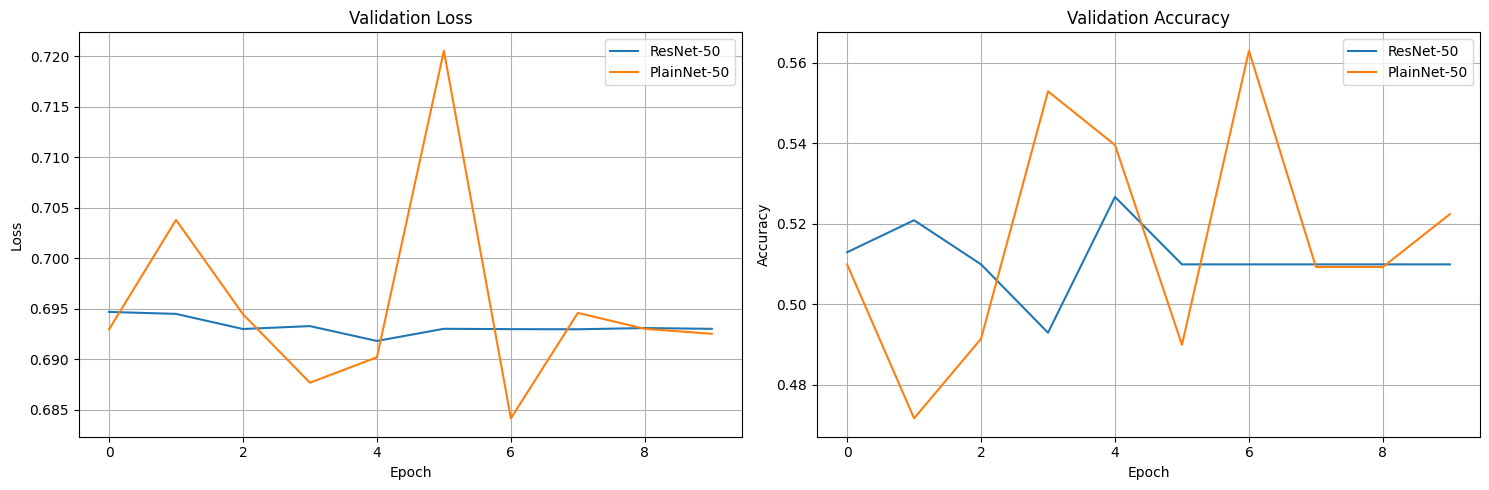

In [34]:
print("\nResNet-50 vs PlainNet-50 비교")
compare_models(resnet50_history, plainnet50_history, 'ResNet-50', 'PlainNet-50')

In [51]:
def create_comparison_tables(resnet34_history, resnet50_history,
                           plainnet34_history, plainnet50_history):
    """세 가지 비교표 생성: ResNet-34 vs 50, ResNet vs PlainNet (34), ResNet vs PlainNet (50)"""

    # 각 모델의 최고 validation accuracy
    accuracies = {
        'ResNet-34': max(resnet34_history.history['val_accuracy']) * 100,
        'ResNet-50': max(resnet50_history.history['val_accuracy']) * 100,
        'PlainNet-34': max(plainnet34_history.history['val_accuracy']) * 100,
        'PlainNet-50': max(plainnet50_history.history['val_accuracy']) * 100
    }

    # 1. ResNet-34 vs ResNet-50
    print("\nResNet Depth Comparison - Validation Accuracy (%)")
    print("-" * 40)
    print(f"{'Model':<15} {'Accuracy':>15}")
    print("-" * 40)
    print(f"{'ResNet-34':<15} {accuracies['ResNet-34']:>15.2f}")
    print(f"{'ResNet-50':<15} {accuracies['ResNet-50']:>15.2f}")
    print("-" * 40)

    # 2. ResNet-34 vs PlainNet-34
    print("\nResNet-34 vs PlainNet-34 - Validation Accuracy (%)")
    print("-" * 40)
    print(f"{'Model':<15} {'Accuracy':>15}")
    print("-" * 40)
    print(f"{'ResNet-34':<15} {accuracies['ResNet-34']:>15.2f}")
    print(f"{'PlainNet-34':<15} {accuracies['PlainNet-34']:>15.2f}")
    print("-" * 40)

    # 3. ResNet-50 vs PlainNet-50
    print("\nResNet-50 vs PlainNet-50 - Validation Accuracy (%)")
    print("-" * 40)
    print(f"{'Model':<15} {'Accuracy':>15}")
    print("-" * 40)
    print(f"{'ResNet-50':<15} {accuracies['ResNet-50']:>15.2f}")
    print(f"{'PlainNet-50':<15} {accuracies['PlainNet-50']:>15.2f}")
    print("-" * 40)

In [52]:
# 결과표 생성
create_comparison_tables(resnet34_history, resnet50_history,
                        plainnet34_history, plainnet50_history)


ResNet Depth Comparison - Validation Accuracy (%)
----------------------------------------
Model                  Accuracy
----------------------------------------
ResNet-34                 55.72
ResNet-50                 52.67
----------------------------------------

ResNet-34 vs PlainNet-34 - Validation Accuracy (%)
----------------------------------------
Model                  Accuracy
----------------------------------------
ResNet-34                 55.72
PlainNet-34               55.20
----------------------------------------

ResNet-50 vs PlainNet-50 - Validation Accuracy (%)
----------------------------------------
Model                  Accuracy
----------------------------------------
ResNet-50                 52.67
PlainNet-50               56.30
----------------------------------------


### 회고
- 백본 모델을 항상 가져다 쓰다가 직접 구현 하려고 보니 많이 어려웠다. 기조가 아직 부족하다.
- 그림을 그려가며 머리속에 좀 더 구조화 시키는 연습이 필요 할 거 같다.
- 시간상 EPOCH 10 으로 설정 하였으나 결과 그래프가 예상과는 많이 차이가 났다.
- 피어 리뷰 후 epoch 수를 늘려서 다시 테스트 할 예정이다.
- LMS 상에서 cats_vs_dogs 다운로드 문제가 colab 에서는 발생 하지 않았는데 tensorflow 버전 차이로 보인다.
- 데이터셋 중에 손상된 이미지가 있는 것으로 보인다. 다행히 colab 로그를 보면 자동으로 그런 이미지는 제외하고 다운로드 받는다고 한다.
- 결과를 보면 ResNet-50 Accuracy 가 ResNet-34 보다 낮게 나왔는데 오버피팅 영향으로 보인다.
- PlainNet-34 와 비교해 보면 근소하게 ResNet-34 가 높게 나왔는데 이 부분도 학습을 충분히 시키면 그 차이가 더 생기지 않을까?
- PlainNet-50 와 비교해 보면 ResNet-50 의 Accuracy 가 더 낮게 나왔다. 이 부분은 이해가 잘 안되는 결과라 디버깅이 필요 할 거 같다.
- Imagenet 데이터셋으로 학습 시켜 Ablation Study 를 진행 할 예정이다.